In [3]:
# 1-1

from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
import sklearn.datasets
import pandas as pd

# SparkSession 초기화
spark = SparkSession.builder.getOrCreate()

# scikit-learn에서 제공하는 데이터를 로드
diabetes = sklearn.datasets.load_diabetes()

# 독립변수와 target 데이터 추출
features = diabetes.data[:, [2, 8]]  # bp와 s5를 선택하여 features로 사용
target = diabetes.target

# 초기 350개의 데이터를 학습 데이터로 사용
train_data = features[:350]
train_target = target[:350]

# 나머지 데이터를 테스트 데이터로 사용
test_data = features[350:]
test_target = target[350:]

# Pandas DataFrame으로 변환
train_df = pd.DataFrame(train_data, columns=['bp', 's5'])
train_df['label'] = train_target

# Spark DataFrame으로 변환
spark_train_df = spark.createDataFrame(train_df)

# VectorAssembler를 사용하여 features 컬럼 생성
assembler = VectorAssembler(inputCols=['bp', 's5'], outputCol='features')
spark_train_df = assembler.transform(spark_train_df)

# 필요한 컬럼만 선택하여 새로운 DataFrame 생성
spark_train_df = spark_train_df.select('features', 'label')

# 결과 출력
spark_train_df.show()

# 먼저, SparkSession을 초기화
# 독립변수와 타겟 데이터를 추출합 -> 독립변수는 모델을 학습하는 데 사용되는 데이터이고, 타겟 데이터는 모델이 예측해야 하는 데이터입니다. 
# 초기 350개의 데이터를 학습 데이터로 사용하고, 나머지 데이터를 테스트 데이터로 사용 ,학습 데이터는 모델을 학습하는 데 사용되고, 테스트 데이터는 모델의 성능을 평가하는 데 사용
# Pandas DataFrame으로 변환 # Spark DataFrame으로 변환
# VectorAssembler를 사용하여 features 컬럼을 생성 ->  VectorAssembler는 여러 개의 컬럼을 하나의 벡터로 결합하는 데 사용되는 Transformer입니다. 이 코드에서는 bp 컬럼과 s5 컬럼을 하나의 벡터로 결합합니다.
# 필요한 컬럼만 선택하여 새로운 DataFrame을 생성 -> 이 코드에서는 features 컬럼과 label 컬럼을 선택하여 새로운 DataFrame을 생성합니다.
# 결과를 출력합니다. 이 코드는 features 컬럼과 label 컬럼을 포함하는 새로운 DataFrame을 출력합니다.


+--------------------+-----+
|            features|label|
+--------------------+-----+
|[0.06169620651868...|151.0|
|[-0.0514740612388...| 75.0|
|[0.04445121333659...|141.0|
|[-0.0115950145052...|206.0|
|[-0.0363846922044...|135.0|
|[-0.0406959404999...| 97.0|
|[-0.0471628129432...|138.0|
|[-0.0018947058402...| 63.0|
|[0.06169620651868...|110.0|
|[0.03906215296718...|310.0|
|[-0.0838084234552...|101.0|
|[0.01750591148957...| 69.0|
|[-0.0288400076873...|179.0|
|[-0.0018947058402...|185.0|
|[-0.0256065714656...|118.0|
|[-0.0180618869484...|171.0|
|[0.04229558918883...|166.0|
|[0.01211685112016...|144.0|
|[-0.0105172024313...| 97.0|
|[-0.0180618869484...|168.0|
+--------------------+-----+
only showing top 20 rows



In [4]:
#1-2
from pyspark.ml.regression import LinearRegression

# LinearRegression 모델 초기화
lr = LinearRegression()

# 모델 학습
lr_model = lr.fit(spark_train_df)

# 학습된 계수와 절편 출력
coefficients = lr_model.coefficients
intercept = lr_model.intercept

print("y = {} * bp + {} * s5 + {}".format(coefficients[0], coefficients[1], intercept))


# 먼저, LinearRegression 클래스를 사용하여 선형 회귀 모델을 초기화 -> 절편 : 선형 회귀 모델에서 절편은 그래프가 y축과 만나는 점을 말합니다. 절편은 독립변수가 모두 0일 때 종속변수의 값을 나타냅니다.
# 다음으로, fit() 메서드를 사용하여 모델을 학습 fit() 메서드는 학습 데이터를 입력으로 받아서 모델을 학습
# 다음으로, coefficients 속성과 intercept coefficients 속성은 독립변수에 대한 계수를 나타내고, intercept 속성은 절편을 나타냅니다.
# 마지막으로, print() 함수를 사용하여 학습된 계수와 절편을 출력


23/05/30 13:49:43 WARN Instrumentation: [a667db33] regParam is zero, which might cause numerical instability and overfitting.
23/05/30 13:49:44 WARN InstanceBuilder$JavaBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
23/05/30 13:49:44 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/05/30 13:49:44 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
23/05/30 13:49:44 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
y = 651.3655440903974 * bp + 636.7807172268164 * s5 + 152.30578264055333


In [5]:
#1-3
from pyspark.ml.evaluation import RegressionEvaluator

# 테스트 데이터를 Spark DataFrame으로 변환
test_df = pd.DataFrame(test_data, columns=['bp', 's5'])
test_df['label'] = test_target
spark_test_df = spark.createDataFrame(test_df)

# VectorAssembler를 사용하여 features 컬럼 생성
spark_test_df = assembler.transform(spark_test_df)
spark_test_df = spark_test_df.select('features', 'label')

# 예측값 계산
predictions = lr_model.transform(spark_test_df)

# 평가 지표 계산
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)

print("RMSE:", rmse)
print("R2 Score:", r2)


#일단 테스트 케이스를 스파크 데이터 프레임으로 바꿈.. 이후에 VectorAssembler를 사용하여 features 컬럼 생성을 생성해서 
#test용 df를 생성한다음 이거를 lr_model 이거에서 제공하는 트랜스퍼 모델에다가 넣어서 예측값을 계산하고
#이 결과 값을 이용하여 평가지표를 계산한다.
#RMSE :  Root Mean Square Error(평균 제곱근 오차)의 약자입니다. 
#회귀 모델의 예측 값과 실제 값 사이의 오차를 평가하는 지표 중 하나입니다. RMSE는 예측 값과 실제 값 사이의 차이를 제곱한 후,
#평균을 구하고 그 결과에 제곱근을 취한 값입니다. RMSE가 작을수록 모델의 예측이 실제 값에 더 가깝다고 할 수 있습니다.

RMSE: 57.299426229236964
R2 Score: 0.4900479632822107


In [7]:
!pip install pykrx

#설치해야함

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.5/127.5 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 1.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [29]:
#2
df = stock.get_market_fundamental("20230523")
print(df.head(2))

# Df 미리 set - 문서 읽어보니 기본으로 KOSPI 로 준다고 하여 따로 설정안했습니다.

          BPS    PER   PBR  EPS   DIV  DPS
티커                                        
095570   8076  22.04  0.55  201  6.09  270
006840  41948   0.00  0.48    0  1.00  200


In [41]:
#2-1
from pykrx import stock

# KOSPI 종목에 대한 2023년 5월 23일자의 DIV, BPS, PER, EPS, PBR 값을 가져옵니다.
df = stock.get_market_fundamental_by_ticker("20230523")
df = df[['DIV', 'BPS', 'PER', 'EPS', 'PBR']]  # 필요한 열만 선택합니다.

from sklearn.preprocessing import StandardScaler

# StandardScaler를 사용하여 데이터를 정규화합니다.
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession

# SparkSession을 초기화합니다.
spark = SparkSession.builder.getOrCreate()

# 데이터프레임을 생성합니다.
df_spark = spark.createDataFrame(df_scaled.tolist(), df.columns.tolist())

# VectorAssembler를 사용하여 입력 특징 벡터를 생성합니다.
assembler = VectorAssembler(inputCols=df.columns.tolist(), outputCol="features")
df_assembled = assembler.transform(df_spark)

# K-Means 모델을 생성하고 학습합니다.
kmeans = KMeans(k=3, seed=1)
model = kmeans.fit(df_assembled)

# 클러스터링 결과를 예측합니다.
predictions = model.transform(df_assembled)

# 각 클러스터에 속하는 종목의 수를 계산합니다.
cluster_counts = predictions.groupBy("prediction").count()
cluster_counts.show()




23/05/30 15:00:52 WARN InstanceBuilder$JavaBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
+----------+-----+
|prediction|count|
+----------+-----+
|         1|  618|
|         0|  298|
|         2|    2|
+----------+-----+



In [43]:
#2-2
# 각 클러스터의 scaling된 값의 중앙점 출력
cluster_centers_scaled = model.clusterCenters()
print("Scaling된 값의 중앙점:")
for i, center in enumerate(cluster_centers_scaled):
    print(f"Cluster {i+1}: {center}")

# scaling 이전 원래 값의 중앙점 출력
scaler_inverse = scaler.inverse_transform(cluster_centers_scaled)
print("\nScaling 이전 원래 값의 중앙점:")
for i, center in enumerate(scaler_inverse):
    print(f"Cluster {i+1}: {center}")


Scaling된 값의 중앙점:
Cluster 1: [ 1.1020987   0.11258108 -0.08446625  0.14903381 -0.19949561]
Cluster 2: [-0.52998281 -0.1115965   0.04113997 -0.13069369  0.09712281]
Cluster 3: [-0.44801673 17.70873687 -0.12678112 18.17831209 -0.28610151]

Scaling 이전 원래 값의 중앙점:
Cluster 1: [4.83120805e+00 7.31497315e+04 9.07661074e+00 6.34892617e+03
 4.94932886e-01]
Cluster 2: [8.39530744e-01 2.83525307e+04 2.97264078e+01 1.64127023e+03
 1.53930421e+00]
Cluster 3: [1.0400000e+00 3.5893735e+06 2.1200000e+00 3.0977150e+05 1.9000000e-01]


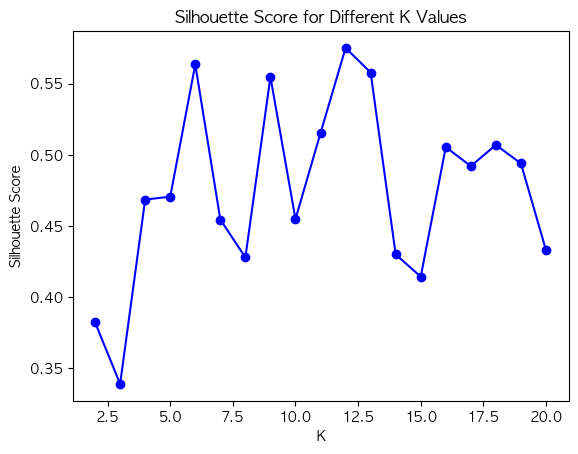

최적의 K 값: 12
실루엣 값: 0.5751289972112273


In [44]:
#2-3
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt

k_values = range(2, 21)  # K 값의 범위 설정
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(k=k, seed=1)
    model = kmeans.fit(df_assembled)
    predictions = model.transform(df_assembled)
    
    evaluator = ClusteringEvaluator()
    silhouette_score = evaluator.evaluate(predictions)
    silhouette_scores.append(silhouette_score)

# 그래프 출력
plt.plot(k_values, silhouette_scores, 'bo-')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different K Values')
plt.show()

# 최적의 K 값과 실루엣 값 출력
best_k = k_values[silhouette_scores.index(max(silhouette_scores))]
best_silhouette = max(silhouette_scores)

print("최적의 K 값:", best_k)
print("실루엣 값:", best_silhouette)
